In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.2 MB/s eta 0:00:00


In [ ]:
!pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 12.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import phik
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 76.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 21.3MB/s]


In [ ]:
try:
    df = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
    test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')
except:
    df = pd.read_csv('https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K')
    test = pd.read_csv('https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r')

## Загрузим данные и изучим общую информацию.

In [ ]:
# df = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
# test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

In [ ]:
df.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3340,13,25.00,332.5,Female,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),0
101,7,20.65,150,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
497,16,19.75,284.35,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
2918,3,78.50,242.05,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,1
2823,40,42.35,1716.45,Male,0,Yes,No,No,No phone service,DSL,Yes,Yes,Yes,No,No,No,One year,Yes,Electronic check,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

5282 строк, 20 столбцов, пропусков нет, типы данных `TotalSpent` надо перевести в числовой

In [ ]:
test.sample(3)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
69,1,54.75,54.75,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Mailed check
183,11,20.95,267.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic)
174,9,19.85,178.8,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

1761 строк, 16 столбцов, пропусков нет, типы данных TotalSpent надо перевести в числовой

In [ ]:
df['TotalSpent'] = pd.to_numeric(df['TotalSpent'], errors='coerce')

In [ ]:
(df.isna().agg(['sum', 'mean'])
    .style.set_caption('Количество пропусков')
    .set_table_styles([{'selector': 'caption',
                     'props': [('color', 'black'), ('font-size', '15px')]
                     }]))

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
sum,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.000000,0.000000,0.001704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
df['TotalSpent'].agg({'mean', 'median'})

mean      2291.390461
median    1410.250000
Name: TotalSpent, dtype: float64

In [ ]:
df[df['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [ ]:
df['TotalSpent'].value_counts()

20.20      9
19.75      8
20.05      6
19.65      6
19.90      5
          ..
41.85      1
4326.25    1
950.20     1
4264.00    1
1375.60    1
Name: TotalSpent, Length: 4977, dtype: int64

В `TotalSpent` появилось 9 пропусков, заполним 0

In [ ]:
df['TotalSpent'] = df['TotalSpent'].fillna(0)

In [ ]:
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'], errors='coerce')

In [ ]:
(test.isna().agg(['sum', 'mean'])
    .style.set_caption('Количество пропусков')
    .set_table_styles([{'selector': 'caption',
                     'props': [('color', 'black'), ('font-size', '15px')]
                     }]))

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
sum,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.000000,0.000000,0.001136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
test['TotalSpent'].agg({'mean', 'median'})

mean      2259.048778
median    1356.700000
Name: TotalSpent, dtype: float64

In [ ]:
test[test['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,NaN,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


В `TotalSpent` появилось 2 пропусков,  заполним 0

In [ ]:
test['TotalSpent'] = test['TotalSpent'].fillna(0)

In [ ]:
print('Количество уникальных значений в каждой колонке:')
for index in df.columns:
    row = df[index].nunique()
    print(f'Уникальный значений {index}: {row}')

In [ ]:
df['Sex'].value_counts(normalize=True)

In [ ]:
test['Sex'].value_counts(normalize=True)

In [ ]:
df['Churn'].value_counts()

In [ ]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
df.describe(include=[object])

Проверим на дубликаты  

In [ ]:
df.duplicated().sum()

In [ ]:
test.duplicated().sum()

3

Дубликатов не много, оставим их

In [ ]:
phik_overview = df.phik_matrix();
phik_overview['Churn'].sort_values(ascending=False)

interval columns not set, guessing: ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen', 'Churn']


Churn                       1.000000
ClientPeriod                0.469423
PaymentMethod               0.442566
MonthlySpending             0.360202
IsBillingPaperless          0.298737
TotalSpent                  0.277363
HasChild                    0.252610
HasContractPhone            0.250575
IsSeniorCitizen             0.242130
HasPartner                  0.229302
HasOnlineSecurityService    0.217454
HasTechSupportAccess        0.208887
HasInternetService          0.192010
HasOnlineBackup             0.178838
HasDeviceProtection         0.171164
HasMovieSubscription        0.140222
HasOnlineTV                 0.139006
HasMultiplePhoneNumbers     0.020756
Sex                         0.000000
HasPhoneService             0.000000
Name: Churn, dtype: float64

матрица корреляций

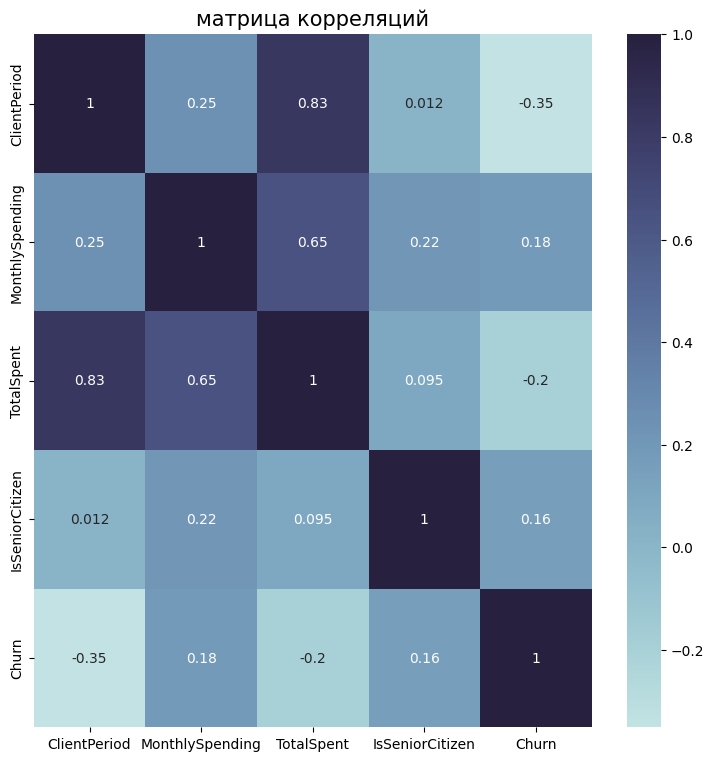

In [ ]:
fig = plt.figure(figsize=(9,9))

sns.heatmap(df.corr(), annot=True, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.title('матрица корреляций', fontsize=15)
plt.show()

## Анализ данных

In [ ]:
df.groupby('Churn').agg(count = ('Churn','count')).reset_index()

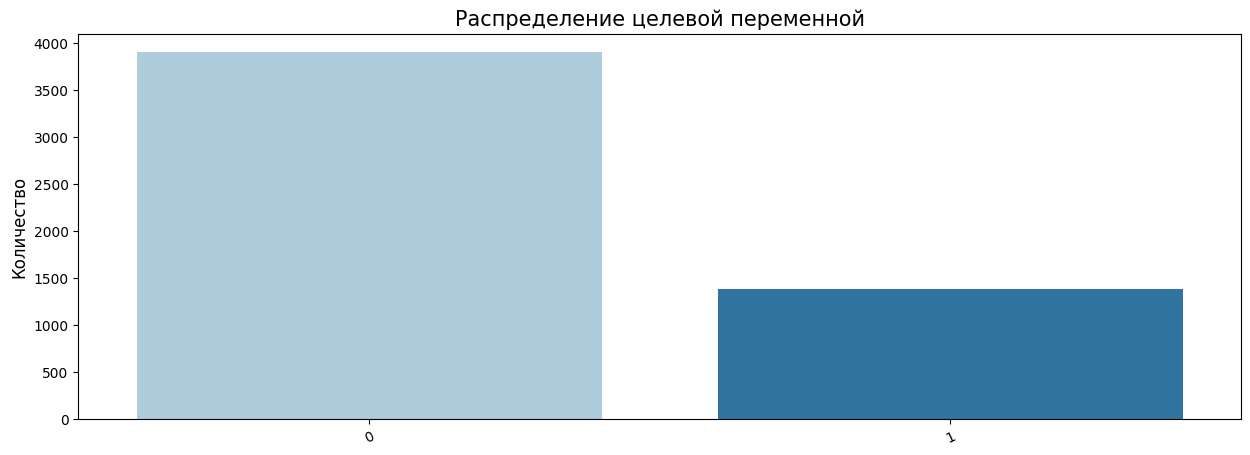

In [ ]:
t = df.groupby('Churn').agg(count = ('Churn','count')).reset_index()
# строим график
plt.figure(figsize=(15,5))
ax = sns.barplot(data = t, x = 'Churn', y = 'count',  palette='Paired')
ax.set_xlabel('',fontsize=12)
ax.set_ylabel('Количество', fontsize=12)
ax.set_title('Распределение целевой переменной', fontsize=15)
plt.xticks(rotation = 25)
plt.show()

In [ ]:
df['Churn'].value_counts(normalize=True)

0    0.737978
1    0.262022
Name: Churn, dtype: float64

классы несбалансированные

Посмотрим на распределение числовых признаков

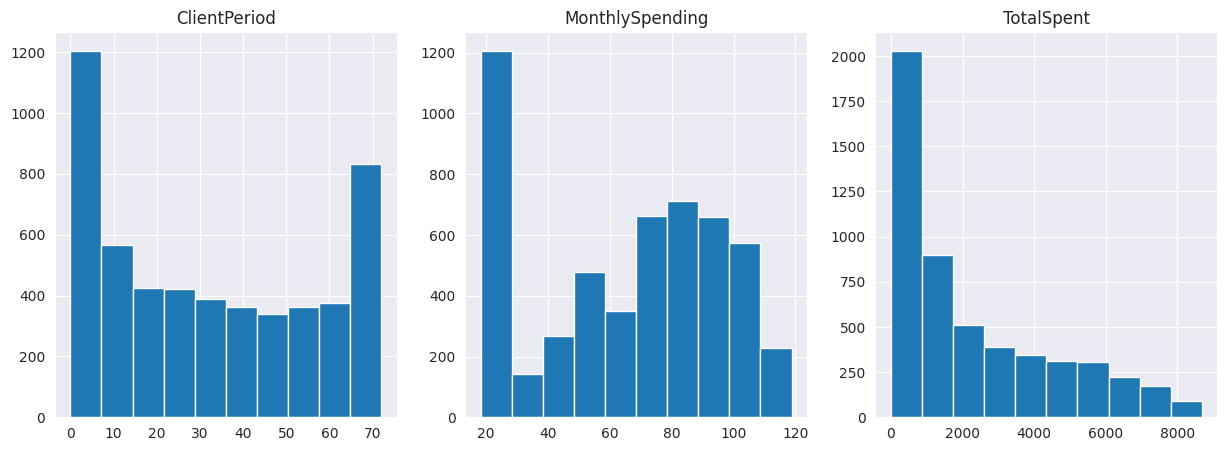

In [ ]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(nrows=1, ncols=len(num_cols), figsize=(15,5))
for i, col in enumerate(num_cols):
    ax[i].hist(df[col])
    ax[i].set_title(col)

Категориальные признаки

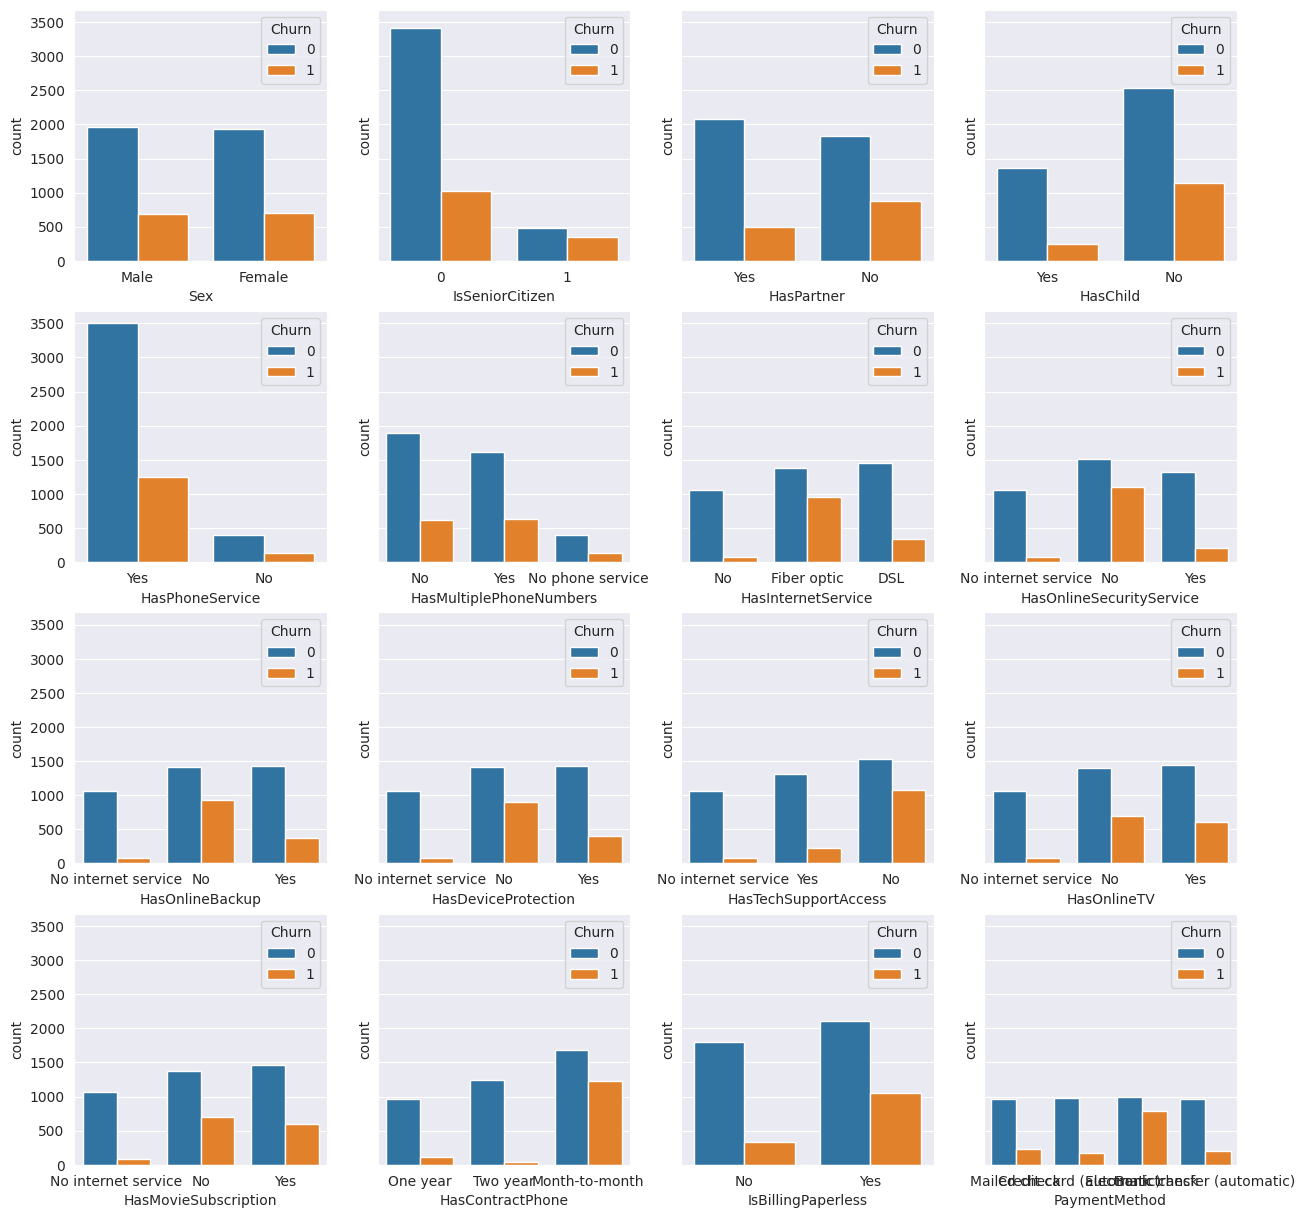

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharey=True)
for i in range(len(cat_cols)):
    sns.countplot(x=cat_cols[i], data=df, ax=axes[i//4, i%4],hue = target_col)

plt.show()

## Подготовим данные для линейных моделей

Скопируем данные

In [ ]:
X_original = df[feature_cols].copy()
X_original.shape

In [ ]:
dummy = pd.get_dummies(df[cat_cols])

Проведём стандартизацию

In [ ]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(df[num_cols])

сформируем датасет

In [ ]:
X = pd.DataFrame(X_train_st, columns=num_cols).join(dummy)
X.sample(3)

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex_Female,Sex_Male,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,...,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2465,1.165186,1.778881,2.238248,0,1,0,1,0,1,0,...,1,0,1,0,0,1,0,0,1,0
2311,0.024564,0.942057,0.354593,0,0,1,0,1,1,0,...,1,1,0,0,0,1,0,0,1,0
3848,-0.871640,-1.316540,-0.866716,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0


In [ ]:
X.shape

(5282, 45)

In [ ]:
y = df[target_col]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_line = LogisticRegressionCV(max_iter=1500)

In [ ]:
grid_cv = GridSearchCV(model_line, param_grid={
                                    'penalty': ['l1', 'l2'],
                                    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'saga']
                                    },

                      scoring='roc_auc',
                      refit=True,
                      n_jobs=-1,
                      verbose=0,
                     )
grid_cv.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegressionCV(max_iter=1500), n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'saga']},
             scoring='roc_auc')

In [ ]:
print(f'Лучшее качество {grid_cv.best_score_}')
print(f'Параметры: {grid_cv.best_params_}')

Лучшее качество 0.8484767039891856
Параметры: {'penalty': 'l1', 'solver': 'saga'}


### CatBoostClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_original, y, train_size=0.8, random_state=42)

Посмотрим на распределение целевой метрики в train и test

In [ ]:
y_train.mean()

In [ ]:
y_test.mean()

Попробуем по дефолту, потом подкрутим

In [ ]:
model_df = CatBoostClassifier(cat_features=cat_cols, eval_metric='AUC:hints=skip_train~false', verbose=100)

In [ ]:
model_df.fit(X_train, y_train)

Learning rate set to 0.019062
0:	learn: 0.8175621	total: 64.7ms	remaining: 1m 4s
100:	learn: 0.8633908	total: 2.7s	remaining: 24s
200:	learn: 0.8735093	total: 4.56s	remaining: 18.1s
300:	learn: 0.8792345	total: 5.8s	remaining: 13.5s
400:	learn: 0.8853834	total: 7.17s	remaining: 10.7s
500:	learn: 0.8936636	total: 8.6s	remaining: 8.56s
600:	learn: 0.9022686	total: 10.1s	remaining: 6.72s
700:	learn: 0.9092997	total: 11.6s	remaining: 4.97s
800:	learn: 0.9155323	total: 13.2s	remaining: 3.27s
900:	learn: 0.9214422	total: 16.3s	remaining: 1.79s
999:	learn: 0.9266072	total: 18s	remaining: 0us


In [ ]:
pred_test = model_df.predict_proba(X_test)[:,1]
pred_train = model_df.predict_proba(X_train)[:,1]
roc_auc_score(y_train, pred_train)

0.8980361281001294

In [ ]:
roc_auc_score(y_test, pred_test)

0.823387759625419

Подправим модель

In [ ]:
params = {
    'verbose':100,
    "learning_rate": 0.05,
    "max_depth": 4,
}

In [ ]:
catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    random_seed=42,
)

In [ ]:
model = CatBoostClassifier(**params,cat_features=cat_cols, eval_metric='AUC:hints=skip_train~false')

In [ ]:
model.fit(X_train, y_train)

0:	learn: 0.7816843	total: 11.6ms	remaining: 11.6s
100:	learn: 0.8632380	total: 930ms	remaining: 8.28s
200:	learn: 0.8724912	total: 1.86s	remaining: 7.39s
300:	learn: 0.8814672	total: 2.82s	remaining: 6.55s
400:	learn: 0.8889999	total: 3.82s	remaining: 5.7s
500:	learn: 0.8948259	total: 4.79s	remaining: 4.77s
600:	learn: 0.8999175	total: 5.78s	remaining: 3.84s
700:	learn: 0.9052059	total: 6.77s	remaining: 2.89s
800:	learn: 0.9109854	total: 7.75s	remaining: 1.93s
900:	learn: 0.9156048	total: 9.16s	remaining: 1.01s
999:	learn: 0.9195272	total: 11.5s	remaining: 0us


In [ ]:
pred_test = model.predict_proba(X_test)[:,1]
pred_train = model.predict_proba(X_train)[:,1]
roc_auc_score(y_train, pred_train)

0.8981201954769433

In [ ]:
roc_auc_score(y_test, pred_test)

0.8234223917400099

### Делаем предсказание

In [ ]:
best_model = model

In [ ]:
try:
    submission = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')
except:
    submission = pd.read_csv('https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y')

In [ ]:
#submission = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv')

In [ ]:
submission['Churn'] = best_model.predict_proba(test)[:,1]

In [ ]:
submission.to_csv("./my_submission.csv", index=False)

In [ ]:
submission.head(2)

,Id,Churn
0,0,0.033193
1,1,0.785759
